# Eigenflows: Visualziation and Discussion

## List of Observations

* Compute eigenflows for flows grouped by length

* For large flows in raw trace, caida, eigenflows are mostly **a single dominant flow**.
    This is not necessarily a bad thing, since this property will change after some perturbation of timestamps, whicm means it's a unique property of the raw data.

* For small flows in raw trace, caida, eigenflows are 
    

In [1]:
import utils.data as data
import utils.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
def perturb_dataset(dataset, input_filename, output_filename, ratio=0.00001):
    df = data.load_data(dataset, input_filename, verbose=False)
    total_duration = df["time"].max()
    
    # perturb timestamp by 0.001% of total duration
    print("Perturb by {}% of total duration".format(ratio*100))
    df["time"] = df["time"] + np.random.uniform(0, total_duration*ratio, size=len(df))

    # sort by time
    df = df.sort_values(by="time")

    print("After perturbation, total duration: {:.3f}".format(df["time"].max() - df["time"].min()))
    df["time"] = df["time"] * 1e6

    df.to_csv(os.path.join("data", dataset, output_filename), index=False)

In [3]:
def flowsize_dist(dataset, filename, flow_tuple, trunc_ratio=1.0):
    df = data.load_data(dataset, filename, verbose=False)
    total_duration = df["time"].max()
    df = df[df["time"] < total_duration * trunc_ratio]
    total_duration = total_duration * trunc_ratio
    print("truncd to first {}% duration: {:.3f}".format(
        trunc_ratio*100, total_duration))

    # dfg = df.groupby(stats.five_tuple)
    # srcip, srcport
    dfg = df.groupby(flow_tuple)

    flowsizes = dfg.size()

    max_raw_flow_header_index = np.argsort(list(flowsizes))[-1]
    max_raw_flow_header = list(dfg.groups.keys())[max_raw_flow_header_index]
    max_raw_flow = dfg.get_group(max_raw_flow_header)

    # print(max_raw_flow)

    # plt.hist(flowsizes, bins=10000, histtype="step")
    print("Grouped by {}, total number of flows: {}".format(
        flow_tuple,
        len(flowsizes)))
    for threshold in [2, 3, 5, 10, 50, 100]:
        num = np.sum(flowsizes < threshold)
        print("#flow w/ size < {}: {}/{}, {:.2f}%".format(
            threshold, num, len(flowsizes), num/len(flowsizes)*100))
    
    if dataset in ["ugr16", "cidds", "ton"]:
        print("max flow has {} records, {} packets, lasts {:.3f} seconds".format(
            len(max_raw_flow), 
            np.sum(max_raw_flow["pkt"]),
            max_raw_flow["time"].max() - max_raw_flow["time"].min()))
    elif dataset in ["caida", "dc"]:
        print("max flow has {} packets, lasts {:.3f} seconds".format(
            len(max_raw_flow), 
            max_raw_flow["time"].max() - max_raw_flow["time"].min()))
    print()

In [7]:
def eigenflow_vis(dataset, filename, time_unit_exp=1, 
        flow_tuple=stats.five_tuple, 
        trunc_ratio=1.0, 
        flowsize_filter=lambda x: x > 0,
        rate_type="packet"):
    # Load caida data
    df = data.load_data(dataset, filename, verbose=False)
    total_duration = df["time"].max() - df["time"].min()

    df = df[df["time"] < total_duration * trunc_ratio]
    total_duration = total_duration * trunc_ratio

    print("Truncated data to {}% of original size, total duration: {}".format(
        trunc_ratio*100, total_duration))

    # group by flow tuple
    print("flow_tuple: {}".format(flow_tuple))
    dfg = df.groupby(flow_tuple)
    
    # get group keys of flows with size > 5
    flowsizes = dfg.size()
    target_flowsizes = flowsizes[flowsize_filter(flowsizes)]
    gks = target_flowsizes.index
    print(len(gks))

    od_flows, trunc_od_flows, U, Sigma, VT, evar, evar_ratio = \
        stats.flow_pca(dfg, gks, total_duration, time_unit_exp, 9, rate_type)


    # print the amount of variance explained by all the eigenflows
    print("explained variance: {}%".format(np.sum(evar_ratio)*100))

    print(od_flows.shape)
    print(evar_ratio.shape)
    print(U.shape)
    print(Sigma.shape)
    print(VT.shape)

    # plot eigenflow
    fig, axes = plt.subplots(9, 2, figsize=(8, 10))

    for i in range(9):
        axes[i, 0].plot(U[:, i])
        axes[i, 0].set_title("U{}, sigma={:.2e}".format(i, Sigma[i]))
        axes[i, 1].plot(VT[i, :])
        axes[i, 1].set_title("VT{}".format(i))
        # add padding between subplots
        fig.subplots_adjust(hspace=1)
        

    # plot first 9 largest od_flows and their reconstructed flows

    # plot explained variance against full variance
    fig, ax = plt.subplots()
    ax.plot(evar_ratio)
    ax.set_title("Explained variance ratio")
    


## Eigenflows of flows with size == 1 of `caida`

Insights:
* PCA of small flows has low explained variance
* PCA of small flows are insensitive to global perturbation of timestamps

In [5]:
flow_tuple = [stats.five_tuple[i] for i in [0, 1, 2, 3, 4]]
trunc_ratio = 0.1
flowsize_filter = lambda x: (x == 1)
# flowsize_dist("caida", "raw.csv", flow_tuple, trunc_ratio=trunc_ratio)

Loading data from:
	data/caida/raw.csv
Number of packets: 998912
Trace duration: 2.3428690433502197 seconds
Truncated data to 10.0% of original size, total duration: 0.23428690433502197
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
11235
Time unit=1.00e-04 with 2342 time intervals and 11235 flows
(2342, 11235)
11235/11235
explained variance: 0.9178328288855975%
(2342, 11235)
(11235,)
(2342, 9)
(9,)
(9, 11235)


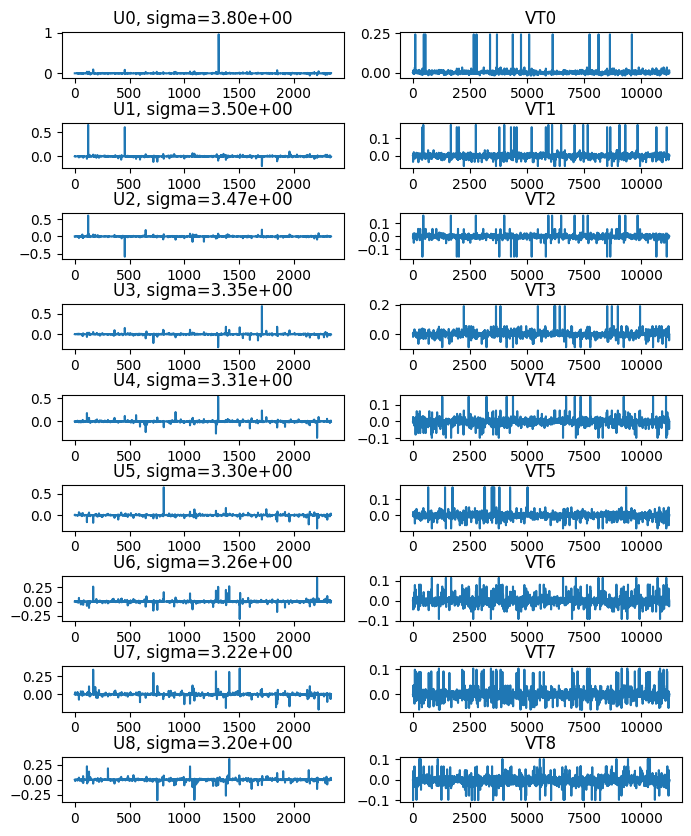

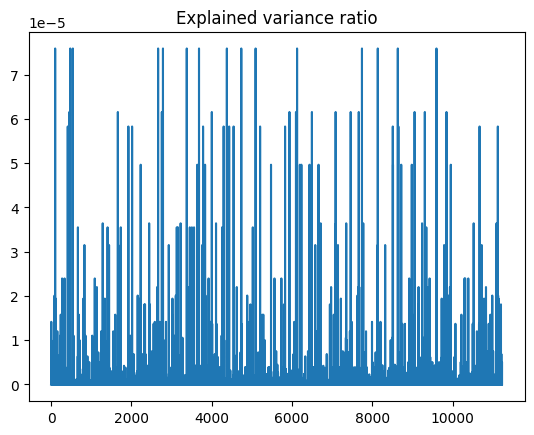

In [8]:
eigenflow_vis("caida", "raw.csv", time_unit_exp=-4, flow_tuple=flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter, rate_type="byte")

Loading data from:
	data/caida/syn.csv
Number of packets: 995152
Trace duration: 2.342869 seconds
Truncated data to 10.0% of original size, total duration: 0.2342869
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
11981
Time unit=1.00e-04 with 2342 time intervals and 11981 flows
(2342, 11981)
11981/11981
explained variance: 3.946518725503781%
(11981,)
(2342, 9)
(9,)
(9, 11981)


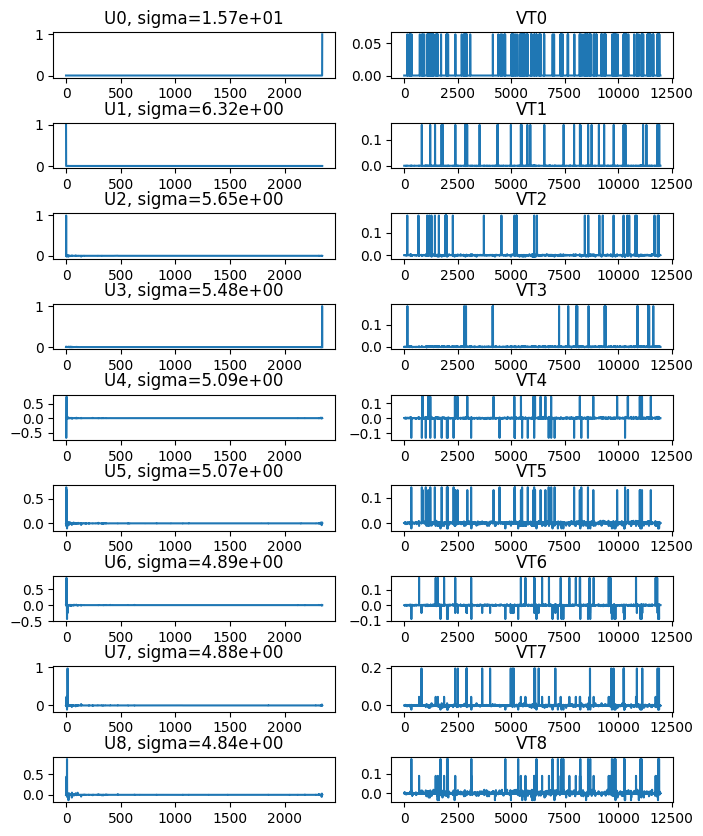

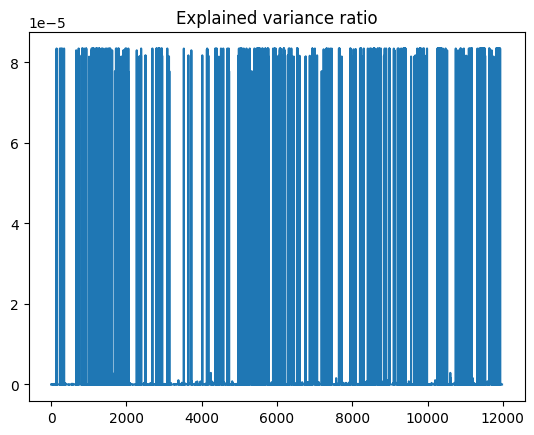

In [15]:
eigenflow_vis("caida", "syn.csv", -4, flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter)

Loading data from:
	data/caida/raw.csv
Number of packets: 998912
Trace duration: 2.3428690433502197 seconds
Perturb by 1.0% of total duration
After perturbation, total duration: 2.365
Loading data from:
	data/caida/perturbed.csv
Number of packets: 998912
Trace duration: 2.365335967548079 seconds
Truncated data to 10.0% of original size, total duration: 0.2365335967548079
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
11003
Time unit=1.00e-04 with 2365 time intervals and 11003 flows
(2365, 11003)
11003/11003
explained variance: 0.9684810670790731%
(11003,)
(2365, 9)
(9,)
(9, 11003)


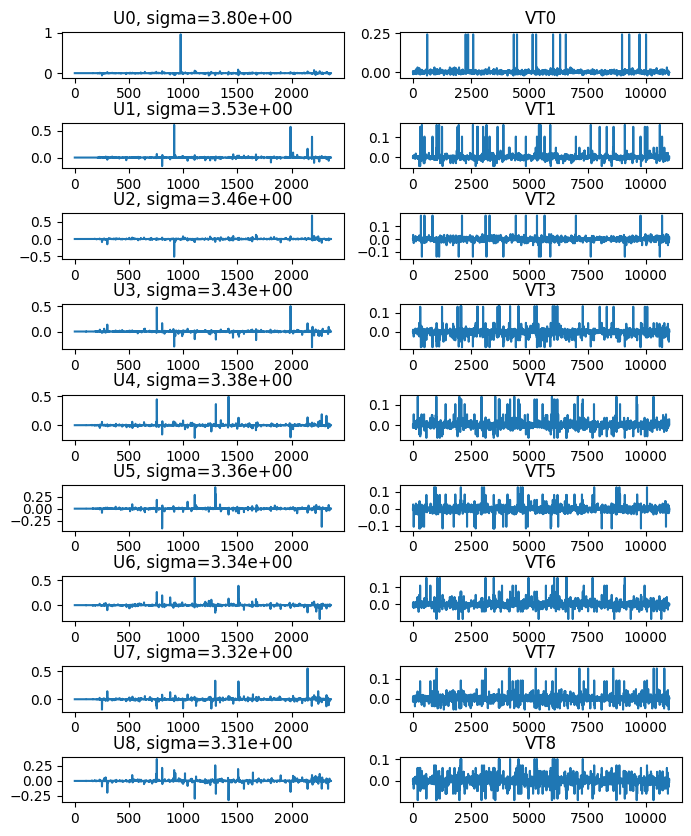

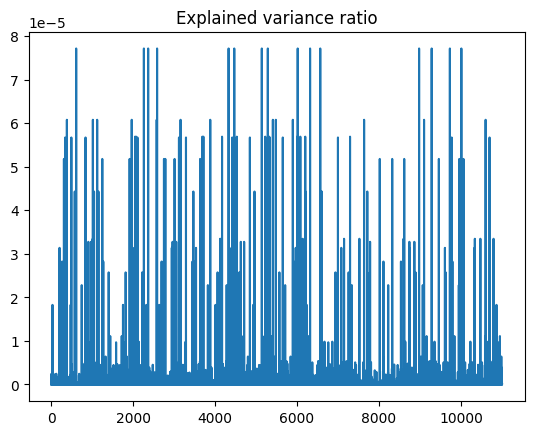

In [16]:
perturb_dataset("caida", "raw.csv", "perturbed.csv", ratio=0.01)
eigenflow_vis("caida", "perturbed.csv", -4, flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter)

Loading data from:
	data/caida/raw.csv
Number of packets: 998912
Trace duration: 2.3428690433502197 seconds
Perturb by 10.0% of total duration
After perturbation, total duration: 2.575
Loading data from:
	data/caida/perturbed.csv
Number of packets: 998912
Trace duration: 2.575021472915934 seconds
Truncated data to 10.0% of original size, total duration: 0.25750214729159343
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
8813
Time unit=1.00e-04 with 2575 time intervals and 8813 flows
(2575, 8813)
8813/8813
explained variance: 1.3210574614820414%
(8813,)
(2575, 9)
(9,)
(9, 8813)


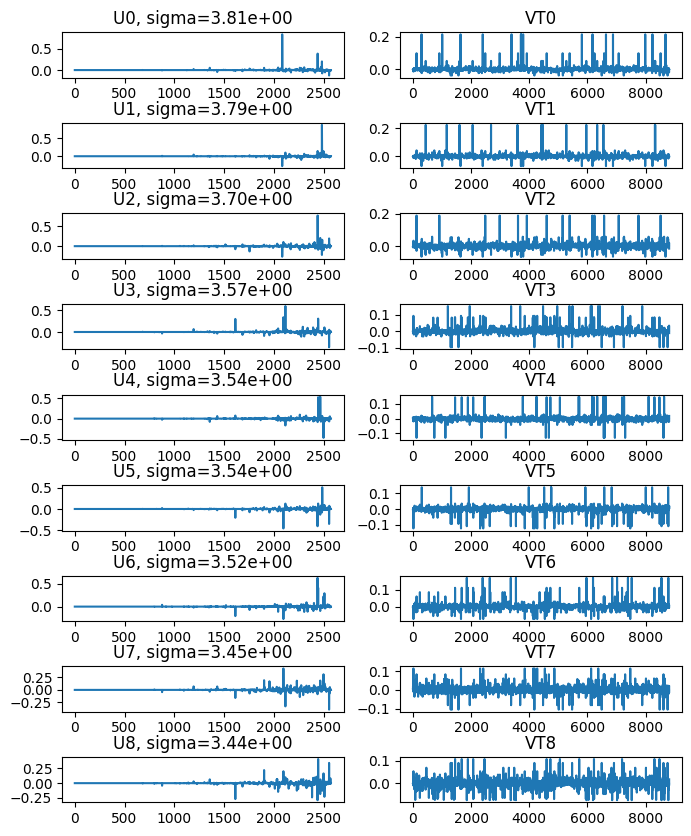

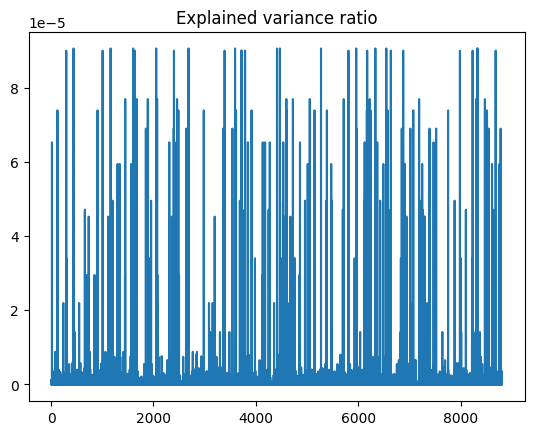

In [17]:
perturb_dataset("caida", "raw.csv", "perturbed.csv", ratio=0.1)
eigenflow_vis("caida", "perturbed.csv", -4, flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter)

## Eigenflows of flows with size > 1000 of `caida`

### Insights:

* PCA of large flows has larger explained ratio

* Eigenflows of large flows are sensitive to global perturbation of timestamps.

* Ratio of explained variance is insentitive to such perturbation

Loading data from:
	data/caida/raw.csv
Number of packets: 998912
Trace duration: 2.3428690433502197 seconds
Truncated data to 100.0% of original size, total duration: 2.3428690433502197
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
109
Time unit=1.00e-04 with 23428 time intervals and 109 flows
(23428, 109)
109/109
explained variance: 33.73451418314583%
(109,)
(23428, 9)
(9,)
(9, 109)


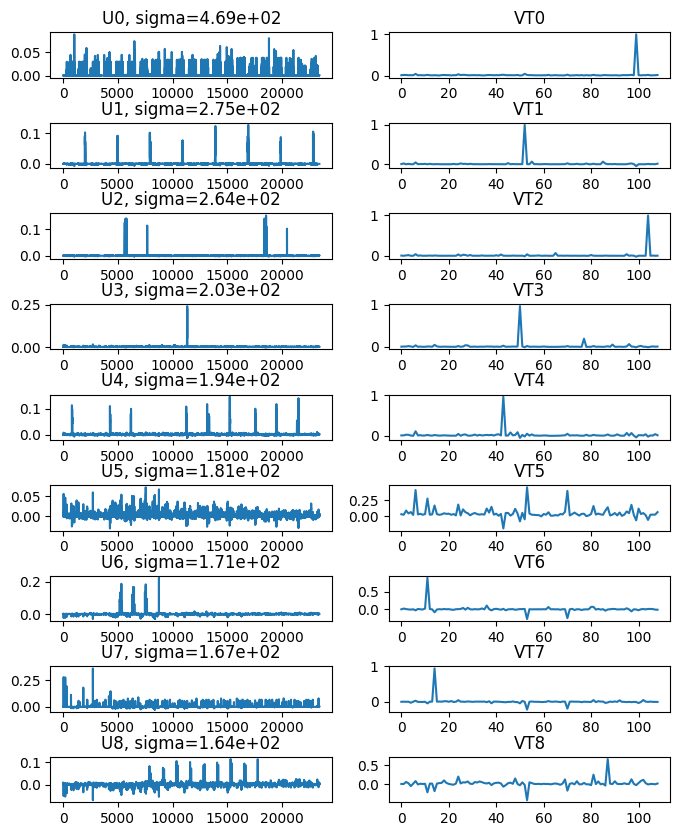

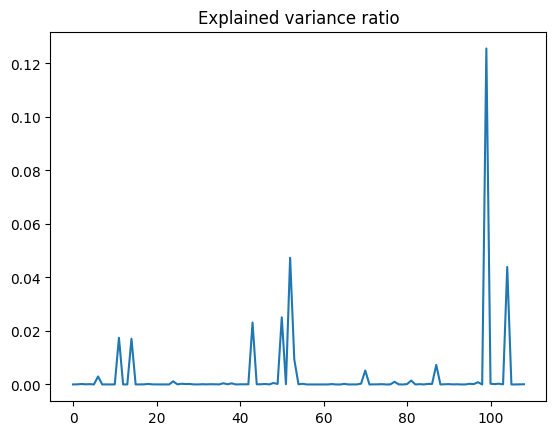

In [18]:
flow_tuple = [stats.five_tuple[i] for i in [0, 1, 2, 3, 4]]
trunc_ratio = 1.0
flowsize_filter = lambda x: (x > 1000)
# flowsize_dist("caida", "raw.csv", flow_tuple, trunc_ratio=trunc_ratio)
eigenflow_vis("caida", "raw.csv", -4, flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter, rate_type="byte")

Loading data from:
	data/caida/syn.csv
Number of packets: 995152
Trace duration: 2.342869 seconds
Truncated data to 100.0% of original size, total duration: 2.342869
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
17
Time unit=1.00e-04 with 23428 time intervals and 17 flows
(23428, 17)
17/17
explained variance: 72.56186413501464%
(17,)
(23428, 9)
(9,)
(9, 17)


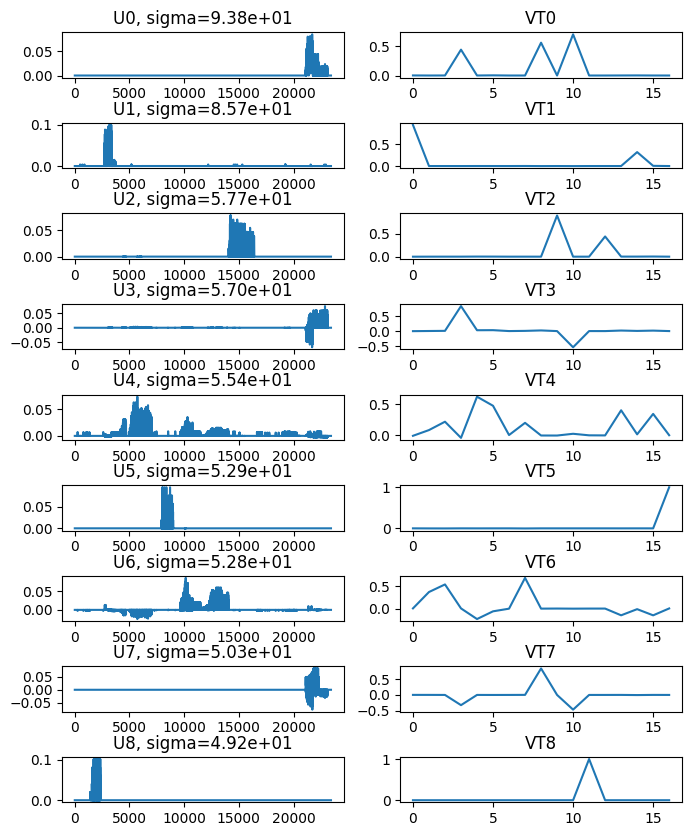

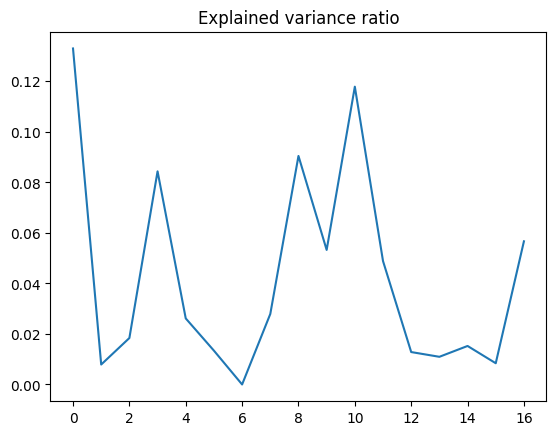

In [19]:
eigenflow_vis("caida", "syn.csv", -4, flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter, rate_type="byte")

Loading data from:
	data/caida/raw.csv
Number of packets: 998912
Trace duration: 2.3428690433502197 seconds
Perturb by 1.0% of total duration
After perturbation, total duration: 2.366
Loading data from:
	data/caida/perturbed.csv
Number of packets: 998912
Trace duration: 2.365636657548389 seconds
Truncated data to 100.0% of original size, total duration: 2.365636657548389
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
109
Time unit=1.00e-04 with 23656 time intervals and 109 flows
(23656, 109)
109/109
explained variance: 31.715728648426868%
(109,)
(23656, 9)
(9,)
(9, 109)


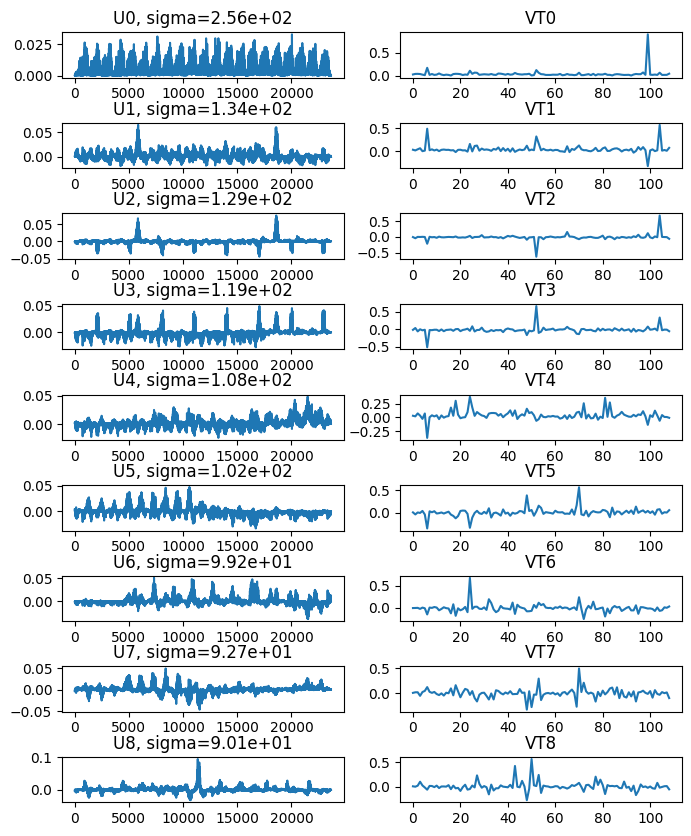

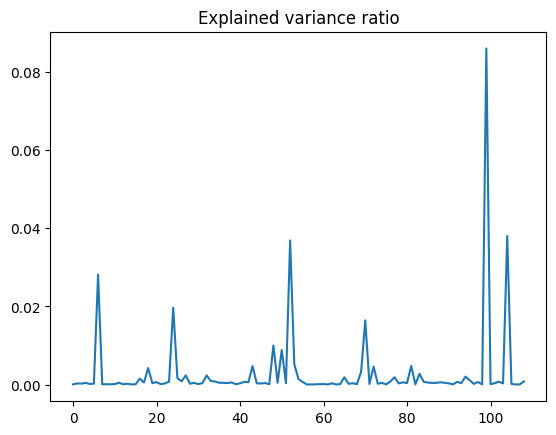

In [20]:
perturb_dataset("caida", "raw.csv", "perturbed.csv", ratio=0.01)
eigenflow_vis("caida", "perturbed.csv", -4, flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter, rate_type="byte")

Loading data from:
	data/caida/raw.csv
Number of packets: 998912
Trace duration: 2.3428690433502197 seconds
Perturb by 10.0% of total duration
After perturbation, total duration: 2.576
Loading data from:
	data/caida/perturbed.csv
Number of packets: 998912
Trace duration: 2.575651022938105 seconds
Truncated data to 100.0% of original size, total duration: 2.575651022938105
flow_tuple: ['srcip', 'srcport', 'dstip', 'dstport', 'proto']
109
Time unit=1.00e-04 with 25756 time intervals and 109 flows
(25756, 109)
109/109
explained variance: 30.458115111578195%
(109,)
(25756, 9)
(9,)
(9, 109)


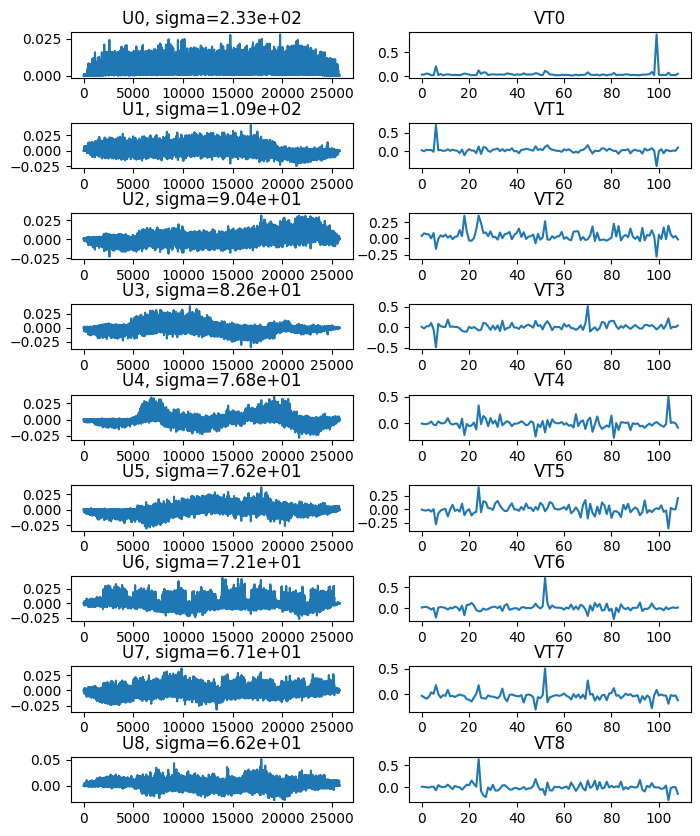

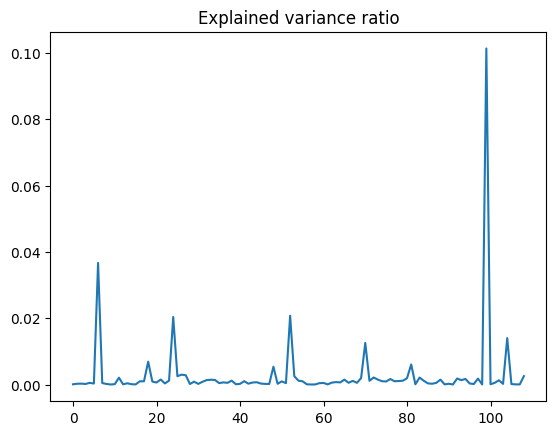

In [21]:
perturb_dataset("caida", "raw.csv", "perturbed.csv", ratio=0.1)
eigenflow_vis("caida", "perturbed.csv", -4, flow_tuple, trunc_ratio=trunc_ratio, flowsize_filter=flowsize_filter, rate_type="byte")